In [3]:
import numpy as np 
import matplotlib.pyplot as plt
from numpy.linalg import norm, svd
from lanczos.lanczos_hm import HighMemoryLanczos

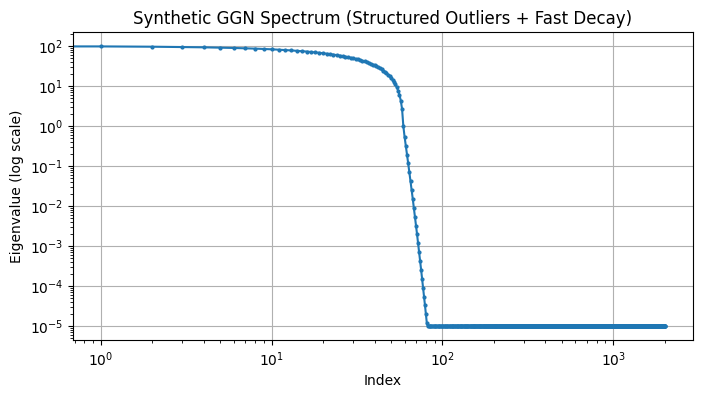

In [149]:
# We'll construct a GGN-style spectrum by mixing structured outliers + exponentially decaying tail

def generate_ggn_style_matrix(n, num_outliers=20, bulk_decay=0.95, noise_floor=1e-5):
    """
    Generate a synthetic GGN-like matrix with a few strong outliers and rapidly decaying bulk.
    """
    # Outlier eigenvalues: large, flat(ish)
    outliers = np.linspace(1e2, 1, num_outliers)

    # Bulk eigenvalues: geometric decay
    num_bulk = n - num_outliers
    bulk = bulk_decay ** np.arange(1, num_bulk + 1)
    bulk = bulk * (outliers[-1] * 0.9)  # ensure separation
    bulk = np.maximum(bulk, noise_floor)  # clip to noise floor

    # Combine and shuffle
    spectrum = np.concatenate([outliers, bulk])
    np.random.shuffle(spectrum)

    # Random orthogonal matrix
    Q, _ = np.linalg.qr(np.random.randn(n, n))
    A = Q @ np.diag(spectrum) @ Q.T
    return A, np.sort(spectrum)[::-1]

# Generate new matrix and visualize the spectrum
A, spectrum_sorted = generate_ggn_style_matrix(n=2000, num_outliers=60, bulk_decay=0.6)

plt.figure(figsize=(8, 4))
plt.plot(spectrum_sorted, marker='o', markersize=2)
plt.xscale('log')
plt.yscale('log')
plt.title("Synthetic GGN Spectrum (Structured Outliers + Fast Decay)")
plt.xlabel("Index")
plt.ylabel("Eigenvalue (log scale)")
plt.grid(True)
plt.show()


In [150]:
spectrum_sorted[:40]

array([100.        ,  98.3220339 ,  96.6440678 ,  94.96610169,
        93.28813559,  91.61016949,  89.93220339,  88.25423729,
        86.57627119,  84.89830508,  83.22033898,  81.54237288,
        79.86440678,  78.18644068,  76.50847458,  74.83050847,
        73.15254237,  71.47457627,  69.79661017,  68.11864407,
        66.44067797,  64.76271186,  63.08474576,  61.40677966,
        59.72881356,  58.05084746,  56.37288136,  54.69491525,
        53.01694915,  51.33898305,  49.66101695,  47.98305085,
        46.30508475,  44.62711864,  42.94915254,  41.27118644,
        39.59322034,  37.91525424,  36.23728814,  34.55932203])

In [151]:
# Correct normalization across columns
def normalize_columns(X):
    return X / np.linalg.norm(X, axis=0, keepdims=True)

def matvec(x):
    return A @ x

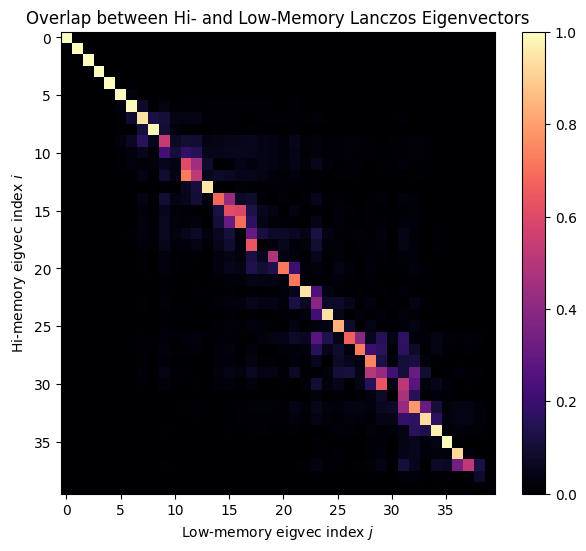

In [152]:
n = A.shape[0]
num_steps = 40

# hi-memory 
solver_hm = HighMemoryLanczos(G_matvec=matvec, p=n)
solver_hm.run(num_steps, ortho=True)

# low-memory 
solver_lm = HighMemoryLanczos(G_matvec=matvec, p=n)
solver_lm.run(num_steps, ortho=False)

vecs_hm, vals_hm = solver_hm.get_top_eigenpairs(k=40, evec=True)
vecs_lm, vals_lm = solver_lm.get_top_eigenpairs(k=40, evec=True)

# vecs_hm = normalize_columns(vecs_hm)
# vecs_lm = normalize_columns(vecs_lm)

overlap = np.abs(vecs_hm.T @ vecs_lm)

# Plot
plt.figure(figsize=(7, 6))
plt.imshow(overlap, cmap="magma", interpolation="nearest", aspect="auto")
plt.colorbar()
plt.title("Overlap between Hi- and Low-Memory Lanczos Eigenvectors")
plt.xlabel("Low-memory eigvec index $j$")
plt.ylabel("Hi-memory eigvec index $i$")
plt.show()



In [153]:
# L * Gamma_L and H * Gamma_H 
weighted_lm = vecs_lm[:, :num_steps] * vals_lm[:num_steps]  # broadcast multiply
weighted_hm = vecs_hm[:, :num_steps] * vals_hm[:num_steps]

# SVD 
U_lm, a, _ = svd(weighted_lm, full_matrices=False)
U_hm, b, _ = svd(weighted_hm, full_matrices=False)

# projection matrices from top-5 principal components
Q_lm = U_lm[:, :5]
Q_hm = U_hm[:, :5]
Pi_lm = Q_lm @ Q_lm.T
Pi_hm = Q_hm @ Q_hm.T

# operator norm
proj_diff = svd(Pi_lm - Pi_hm, compute_uv=False)[0]
proj_diff

0.013713831567122704